In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import os
import seaborn as sns

# Investigating Stock Price Influences: The Impact of Tweets, Insider Trading, and Earnings

## Abstract

TODO write an abstract

## 1. Introduction

The stock market is a complex system influenced by many factors. All of the people, that trade long or short term stocks, always seek ways to dynamics, that drive stock prices. The traditional financial indicators like earnings, financial statements and insider trading activities have long been linked with influincing the market. The rise of social media and the interconnected world, we live in, introduces a new dimension to market analysis. The social network websites like twitter and reddit are considered to potentially trigger a market movement. We have observed such cases in the last couple of years, for example with Gamestop and Dogecoin, but does it happen more often and is it as reliable as the traditional indicators?

This project aims to investigate how various factors, that influence stock prices. By leveraging multiple datasets, comprehensive analysis will be conducted, in order to identify the extent to which these factors impact stock market behavior and what factors seem to be more useful than others.

- **What is the stock market?**

Explain what the stock market is, how it is moved and how people make money potentially?
https://www.investopedia.com/terms/s/stockmarket.asp
Stocks vs indexes

- **What factors make the stock move?**

In here explain about technical analysis, financials, insider trading etc
https://www.investopedia.com/articles/basics/04/100804.asp


Explain the terms and so on from the above points

What is a stock split? Dividend?

## 2. Data Collection and Preparation

- **Overview**

To conduct a comprehensive analysis of the factors influencing stock prices, we have utilized a diverse set of datasets from Kaggle. These datasets encompass a range of information, including stock market data, insider trading activities, financial indicators, social media sentiment, and earnings data. Below is an overview of each dataset:

   1. **Stock Market Data**:
      
      - **Source**: [Price Volume Data for All U.S. Stocks & ETFs](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)
   
   This dataset includes price and volume data for all U.S. stocks and ETFs, offering a comprehensive view of market movements over time. It provides essential information such as opening and closing prices, highest and lowest prices, and trading volumes.

   The dataset is in multiple csv files, located in "stocks_data" folder. Lets begin by reading all the csv's and combining them to a dataframe.

   Each csv contains information about the date, stock prices throughout it, volume, paid dividends and stock splits. That is why, when adding to to a big dataframe, we need to extract the stock ticker, so we can differentiate them.

In [3]:
def load_csv_data(folder_path):
    """
    Load and concatenate stock data from multiple CSV files in a given folder.
    
    Parameters:
    folder_path (str): The path to the folder containing the CSV files.
    
    Returns:
    pd.DataFrame: A concatenated DataFrame containing data from all CSV files, with an additional 'ticker' column.
    """
    dataframes = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            temp_df = pd.read_csv(file_path)
            
            ticker = file_name.replace(".csv", "")
            
            temp_df['ticker'] = ticker
            
            dataframes.append(temp_df)

    combined_data = pd.concat(dataframes, ignore_index=True)

    return combined_data

stock_data = load_csv_data('stocks_data')
stock_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
0,1999-11-18,27.896016,30.654965,24.523970,26.976368,62546380.0,0.0,0.0,A
1,1999-11-19,26.324950,26.363270,24.409017,24.753885,15234146.0,0.0,0.0,A
2,1999-11-22,25.328663,26.976368,24.562289,26.976368,6577870.0,0.0,0.0,A
3,1999-11-23,26.056724,26.746461,24.523975,24.523975,5975611.0,0.0,0.0,A
4,1999-11-24,24.600619,25.711862,24.523981,25.175400,4843231.0,0.0,0.0,A


In [4]:
stock_data.dtypes

Date             object
Open            float64
High            float64
Low             float64
Close           float64
Volume          float64
Dividends       float64
Stock Splits    float64
ticker           object
dtype: object

Let's do some cleaning of the dataset. The data types seem to be correct apart from the date column. The columns need to be changed to python-like names.

Since we will be investigating a lot of datasets and much bigger ones, lets create a script for it.

In [5]:
def convert_to_snake_case(df):
    """
    Converts all column names in a DataFrame to snake_case.
    
    Parameters:
    df: The DataFrame whose columns need to be renamed.
    
    Returns:
    pd.DataFrame: A DataFrame with column names in snake_case.
    """
    def snake_case(s):
        snake_case = s
        snake_case = re.sub(r' ', '_', snake_case)
        return snake_case.lower()
    
    # Apply snake_case to all column names
    return [snake_case(col) for col in df.columns]

In [6]:
stock_data_tidy = stock_data
stock_data_tidy.columns = convert_to_snake_case(stock_data)

In [7]:
stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)

In [8]:
stock_data_tidy.dtypes

date            datetime64[ns]
open                   float64
high                   float64
low                    float64
close                  float64
volume                 float64
dividends              float64
stock_splits           float64
ticker                  object
dtype: object

In [9]:
len(stock_data_tidy.groupby(stock_data_tidy.ticker))

503

In [10]:
stock_data_tidy.date.min(), stock_data_tidy.date.max()

(Timestamp('1962-01-02 00:00:00'), Timestamp('2022-07-12 00:00:00'))

There is information about 503 different stocks in the dataset with their prices in the timeframe 1962 - 2022. Although not all stocks have this timeframe.

Let's make dividends and stock splits to NaN, where they are 0, since 0 is not a correct value for it.

In [11]:
stock_data_tidy.dividends = stock_data_tidy.dividends.where(stock_data_tidy.dividends != 0, np.nan)
stock_data_tidy.stock_splits = stock_data_tidy.stock_splits.where(stock_data_tidy.stock_splits != 0, np.nan)

In [12]:
len(stock_data_tidy[stock_data_tidy.dividends.notna()]), len(stock_data_tidy[stock_data_tidy.stock_splits.notna()])

(45165, 1566)

There are a total of 45 165 dividend pay outs and 1566 stock spits in the dataset.

In [13]:
# TODO if have time make some charts -> most dividends, check stock splits by date (also dividends maybe) etc..

   2. **Insider Trading Data**:
      
      - **Source**: [Insider Trading S&P 500 Inside Info](https://www.kaggle.com/datasets/ilyaryabov/insider-trading-sp500-inside-info)

This dataset shows insider trading activities, including trades made by executives and other insiders within S&P 500 companies. Information includes the type of trade (buy/sell), the number of shares traded, and the position of the insider within the company.

Here the data is again in files, separated for each company. Let's read it.

In [14]:
insider_trading = load_csv_data('insider_trading')

insider_trading.head()

,Insider Trading,Relationship,Date,Transaction,Cost,Shares,Value ($),Shares Total,SEC Form 4,ticker
0,Ancher-Jensen Henrik,Sr Vice President,2022-12-14,Sale,155.78,"29,500","4,595,510","70,793",Dec 15 12:22 PM,A
1,Grau Dominique,Senior Vice President,2022-12-13,Sale,159.20,"4,000","636,800","92,379",Dec 15 12:20 PM,A
2,MCDONNELL PADRAIG,Sr. Vice President,2022-12-13,Sale,160.00,672,"107,520","15,529",Dec 15 12:21 PM,A
3,KOH BOON HWEE,Director,2022-12-06,Sale,152.21,"13,000","1,978,692","57,752",Dec 08 11:31 AM,A
4,Thaysen Jacob,Sr. Vice President,2022-12-01,Sale,155.65,"3,235","503,528","84,464",Dec 02 01:45 PM,A


In [15]:
insider_trading.dtypes

Insider Trading     object
Relationship        object
Date                object
Transaction         object
Cost               float64
Shares              object
Value ($)           object
Shares Total        object
SEC Form 4          object
ticker              object
dtype: object

As we can see the data types here are almost all in the wrong data type and also the names are not in snake case. Let's fix it.

In [16]:
insider_trading_tidy = insider_trading

insider_trading_tidy.columns = convert_to_snake_case(insider_trading_tidy)

In [17]:
insider_trading_tidy = insider_trading_tidy.rename(columns={'value_($)': 'value', 'sec_form_4': 'sec_form', 'insider_trading': 'name'})

In [18]:
insider_trading_tidy.head()

,name,relationship,date,transaction,cost,shares,value,shares_total,sec_form,ticker
0,Ancher-Jensen Henrik,Sr Vice President,2022-12-14,Sale,155.78,"29,500","4,595,510","70,793",Dec 15 12:22 PM,A
1,Grau Dominique,Senior Vice President,2022-12-13,Sale,159.20,"4,000","636,800","92,379",Dec 15 12:20 PM,A
2,MCDONNELL PADRAIG,Sr. Vice President,2022-12-13,Sale,160.00,672,"107,520","15,529",Dec 15 12:21 PM,A
3,KOH BOON HWEE,Director,2022-12-06,Sale,152.21,"13,000","1,978,692","57,752",Dec 08 11:31 AM,A
4,Thaysen Jacob,Sr. Vice President,2022-12-01,Sale,155.65,"3,235","503,528","84,464",Dec 02 01:45 PM,A


In [19]:
insider_trading_tidy.date = pd.to_datetime(insider_trading_tidy.date)

# Sec Form requires more preparation, since it has only date, no year
insider_trading_tidy.sec_form = pd.to_datetime(insider_trading_tidy.sec_form, format='%b %d %I:%M %p', errors='coerce')
insider_trading_tidy['year'] = pd.to_datetime(insider_trading_tidy.date).dt.year
insider_trading_tidy.sec_form = insider_trading_tidy.sec_form.apply(lambda x: x.replace(year=insider_trading_tidy.year[0]))

insider_trading_tidy = insider_trading_tidy.drop(columns=['year'])

insider_trading_tidy.shares = insider_trading_tidy.shares.str.replace(',', '').astype(float)
insider_trading_tidy.value = insider_trading_tidy.value.str.replace(',', '').astype(float)
insider_trading_tidy.shares_total = insider_trading_tidy.shares_total.str.replace(',', '').astype(float)

In [20]:
insider_trading_tidy.dtypes

name                    object
relationship            object
date            datetime64[ns]
transaction             object
cost                   float64
shares                 float64
value                  float64
shares_total           float64
sec_form        datetime64[ns]
ticker                  object
dtype: object

In [21]:
len(insider_trading_tidy.groupby(insider_trading_tidy.ticker))

494

Now the data is in much better formats and easy to work with. There seem to be 494 different tickers.

In [22]:
unique_relationships = insider_trading_tidy.relationship.unique()

print(len(unique_relationships))

2059


I thought of maybe converting the relationship to be the same value for the different roles, but there are a bit too much data in this column. For now let's leave it like this and if needed, come back and do it.

In [23]:
# TODO if have time make some charts -> most insider traded stocks, sale/buys of insiders per stocks and some sort of this

   3. **Financial Indicators**:
      
      - **Source**: [200 Financial Indicators of U.S. Stocks (2014-2018)](https://www.kaggle.com/datasets/cnic92/200-financial-indicators-of-us-stocks-20142018)

This dataset provides a wide range of financial indicators for U.S. stocks, covering metrics such as profitability, liquidity, leverage, and valuation from 2014 to 2018. These indicators are critical for assessing the financial health and performance of companies.

The dataset, that will be used can be found in the folder "financial_indicators". It contains information for 5 years (2014-2018) for many stocks. Lets read it.

In [24]:
folder_path = 'financial_indicators'
dataframes = []

for file_name in os.listdir(folder_path):
    year = file_name.split('_')[0]
    
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    
    df['year'] = int(year)
    
    dataframes.append(df)

financial_indicators = pd.concat(dataframes, ignore_index=True)

financial_indicators.head()

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class,year,2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%]
0,PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,...,0.0000,-0.1746,Consumer Defensive,-9.323276,0,2014,NaN,NaN,NaN,NaN
1,VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,1.6484,1.7313,Consumer Defensive,-25.512193,0,2014,NaN,NaN,NaN,NaN
2,KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,...,0.0000,0.0234,Consumer Defensive,33.118297,1,2014,NaN,NaN,NaN,NaN
3,RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,...,0.0000,-0.0060,Consumer Defensive,2.752291,1,2014,NaN,NaN,NaN,NaN
4,GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,...,0.0000,-0.0220,Consumer Defensive,12.897715,1,2014,NaN,NaN,NaN,NaN


In [25]:
financial_indicators_tidy = financial_indicators
financial_indicators_tidy.columns = convert_to_snake_case(financial_indicators_tidy)

financial_indicators_tidy = financial_indicators_tidy.rename(columns={'unnamed:_0': 'ticker'})
print(list(financial_indicators_tidy.dtypes))
print(len(financial_indicators.groupby(financial_indicators_tidy.ticker)))
print(financial_indicators_tidy.columns)

[dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'

This dataset contains a lot of columns and data about all the possible financial indicators of the stocks. The columns seem to be in the correct data types.

There are 4980 different stocks. In the above datasets we had only 503 most popular tickers, so we will investigate only the 503 we have the prices for.

   4. **Tweets for Sentiment Analysis**:
      
      - **Source**: [Stock Tweets for Sentiment Analysis and Prediction](https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction)
      
This dataset includes tweets related to stock market sentiment. Each tweet has a stock name attached to it. The dataset is useful for analyzing the correlation between social media sentiment and market movements.

Let's now read the data and see what we have.

In [26]:
tweet_data = pd.read_csv('tweet_data/stock_tweets.csv')

In [27]:
tweet_data_tidy = tweet_data

tweet_data_tidy.columns = convert_to_snake_case(tweet_data_tidy)

tweet_data_tidy.date = pd.to_datetime(tweet_data_tidy.date)

tweet_data_tidy = tweet_data_tidy.rename(columns={'stock_name': 'ticker'})

In [28]:
tweet_data_tidy

,date,tweet,ticker,company_name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


As we can see there are the tweets with their dates and the company, about which is the tweet. The data is from years 2021 - 2022.

In [29]:
tweet_data_tidy.ticker.value_counts()

ticker
TSLA    37422
TSM     11034
AAPL     5056
PG       4089
AMZN     4089
MSFT     4089
NIO      3021
META     2751
AMD      2227
NFLX     1727
GOOG     1291
PYPL      843
DIS       635
BA        399
COST      393
INTC      315
KO        310
CRM       233
XPEV      225
ENPH      216
ZS        193
VZ        123
BX         50
NOC        31
F          31
Name: count, dtype: int64

There are 25 different stocks in the datasaet, the most tweets of which are about Tesla, which is quite normal, since the owner of twitter Elon Musk, also owns Tesla.

Sentiment analysis needs to be performed on the data and then inspect, whether the tweets affect the price.

   5. **Earnings Data**:

      - **Source**: [U.S. Historical Stock Prices with Earnings Data](https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data)

This dataset focuses on stock price movements around earnings announcements. It includes historical stock prices and earnings data, allowing for the analysis of how earnings reports impact stock prices both in the short-term and long-term.

In [30]:
earnings_data = pd.read_csv('earnings_data/earnings_latest.csv')
earnings_data

,symbol,date,qtr,eps_est,eps,release_time
0,A,2009-05-14,04/2009,NaN,NaN,post
1,A,2009-08-17,07/2009,NaN,NaN,post
2,A,2009-11-13,10/2009,NaN,NaN,pre
3,A,2010-02-12,01/2010,NaN,NaN,pre
4,A,2010-05-17,04/2010,NaN,NaN,post
...,...,...,...,...,...,...
168598,ZYXI,2020-02-27,Q4,0.077,0.09,post
168599,ZYXI,2020-04-28,Q1,0.063,0.09,post
168600,ZYXI,2020-07-28,Q2,0.086,0.09,post
168601,ZYXI,2020-10-27,Q3,0.053,0.04,post


This datasest will require a bit more preparation. Why do we need data without eps and eps_est. It is basically useless.

Also the quarters seem to be in all kind of different dates, but we arae not going to be using them in our research, since we only need the dates. Let's tidy the dataset.

In [31]:
earnings_data_tidy = earnings_data

earnings_data_tidy = earnings_data_tidy.rename(columns={'symbol': 'ticker'})

# Remove columns, where we don't have eps and eps_est
earnings_data_tidy = earnings_data_tidy.drop(earnings_data_tidy[(earnings_data_tidy.eps.isna()) | (earnings_data_tidy.eps_est.isna())].index)

# Drop quarter column, since we don't need it
earnings_data_tidy = earnings_data_tidy.drop(columns=['qtr'])

In [32]:
earnings_data_tidy.date = pd.to_datetime(earnings_data_tidy.date)

In [33]:
len(earnings_data_tidy.ticker.unique())

5075

In [34]:
earnings_data_tidy.date.min(), earnings_data_tidy.date.max()

(Timestamp('2012-07-16 00:00:00'), Timestamp('2021-06-14 00:00:00'))

We seem to have 5075 different tickers, with their corresponding earnings data and the dates are from 2012 up until mid 2021

## 3. Financial Statements and Long-term Stock Price Trends
- **Hypothesis**: Earnings reports have a significant impact on stock prices, both short-term and long-term.
- **Data Analysis**:
  - Immediate effect of earnings announcements on stock prices.
  - Long-term impact of positive and negative earnings on stock price trends.
- **Methods**:
  - Event study methodology to assess immediate price reactions.
  - Time series analysis for long-term impact.
  - Regression analysis to understand the relationship between earnings surprises and price changes.
- **Visualization**: Display results and key findings.

TODO do the following:

Earnings:

I want to know the immediate effects of the earnings -> in 5-10 days, what is going to happen to the stock price

I want to know the long term effect of the earnings -> what happens if one report is positive

In [265]:
# Merge the stock and earnings data on ticker and date
merged_data = pd.merge(stock_data_tidy, earnings_data_tidy, on=['ticker', 'date'])

In [266]:
merged_data.sort_values(by=['ticker', 'date'], inplace=True)

In [267]:
event_window_start = -12
event_window_end = 12

In [268]:
merged_data = merged_data.drop(columns=['dividends', 'stock_splits'])

Add data for prices before and after each earnings. There is a difference between the release times. If the release time is 'pre', then we should get the day before the earnings report. If it is 'post', we should get the actual day of earnings.

In [269]:
merged_data['date_before_earnings'] = merged_data.apply(
    lambda row: row['date'] if row['release_time'] == 'post' else row['date'] - pd.Timedelta(days=1),
    axis=1
)

# Merge with stocks data to get the price and corresponding date on or before earnings date
merged_data = pd.merge_asof(
    merged_data.sort_values('date_before_earnings'),
    stock_data_tidy[['ticker', 'date', 'close']].sort_values('date'),
    left_on='date_before_earnings',
    right_on='date',
    by='ticker',
    direction='backward',
    suffixes=('', '_from_stock_data')
)
merged_data.rename(columns={'close_from_stock_data': 'price_before_earnings'}, inplace=True)

Then we adjust the prices. We want to have consistency, since the stock market works only in working days and we should exclude Saturday, Sunday and holidays. For example 8 days before earnings, could be 10 days in real life. We want to get 8 days of trading, not holidays.

In [270]:
def check_before_or_after(day):
    return "before" if day < 0 else "after"

for day in range(event_window_start, event_window_end):
    date_column = f'date_{abs(day)}_days_{check_before_or_after(day)}'
    
    adjusted_date = merged_data['date_before_earnings'] + pd.Timedelta(days=day)
    
    merged_data[date_column] = adjusted_date
    
    # Merge to find the closest available date with data in stock data
    merged_data = pd.merge_asof(
        merged_data.sort_values(date_column),
        stock_data_tidy[['ticker', 'date', 'close']].sort_values('date'),
        left_on=date_column,
        right_on='date',
        by='ticker',
        direction='backward',
        suffixes=('', f'_{abs(day)}_days_{check_before_or_after(day)}')
    )
    
    new_column_name = f'price_{abs(day)}_days_{check_before_or_after(day)}'
    merged_data.rename(columns={f'close_{abs(day)}_days_{check_before_or_after(day)}': new_column_name}, inplace=True)
    
    merged_data[date_column] = merged_data['date']
    
    merged_data.drop(columns=['date'], inplace=True)

In [271]:
def calculate_diff_percent(first, second, threshold=1e-5):
    if abs(second) < threshold:
        return 0  # Avoid division by zero or near-zero
    else:
        return ((first - second) / abs(second)) * 100

In [272]:
merged_data['eps_diff_percent'] = merged_data.apply(
    lambda row: calculate_diff_percent(row['eps'], row['eps_est'], 1e-5), axis=1
)

Lets remove the percentages > 2000 and < 2000, since they are very few of then and are more of an outliers.

In [273]:
len(merged_data[(merged_data.eps_diff_percent < -2000) | (merged_data.eps_diff_percent > 2000)])

13

In [274]:
merged_data = merged_data.drop(merged_data[(merged_data.eps_diff_percent < -2000) | (merged_data.eps_diff_percent > 2000)].index)

Next let's categorize the eps differences. 0.5% will be the neutral mark.

In [275]:
neutral_threshold = 0.5 

merged_data['eps_category'] = np.where(
    merged_data['eps_diff_percent'] > neutral_threshold, 'Positive Surprise',
    np.where(
        merged_data['eps_diff_percent'] < -neutral_threshold, 'Negative Surprise',
        'Near Zero'
    )
)

Next up let's find the percentage differences between the prices each day. We compare with the price before earnings, since it is most accurate measurement and we can easily plot it.

In [276]:
# Calculate the percentage change for each day before and after the earnings announcement
for day in range(1, event_window_end - 1):
    merged_data[f'change_{day}_days_before'] = merged_data.apply(
        lambda row: calculate_diff_percent(row[f'price_{day}_days_before'], row[f'price_before_earnings']), axis=1
    )

    merged_data[f'change_{day}_days_after'] = merged_data.apply(
        lambda row: calculate_diff_percent(row[f'price_{day}_days_after'], row[f'price_before_earnings']), axis=1
    )

We finally have all the data we need. Let's do some plotting and investigating.

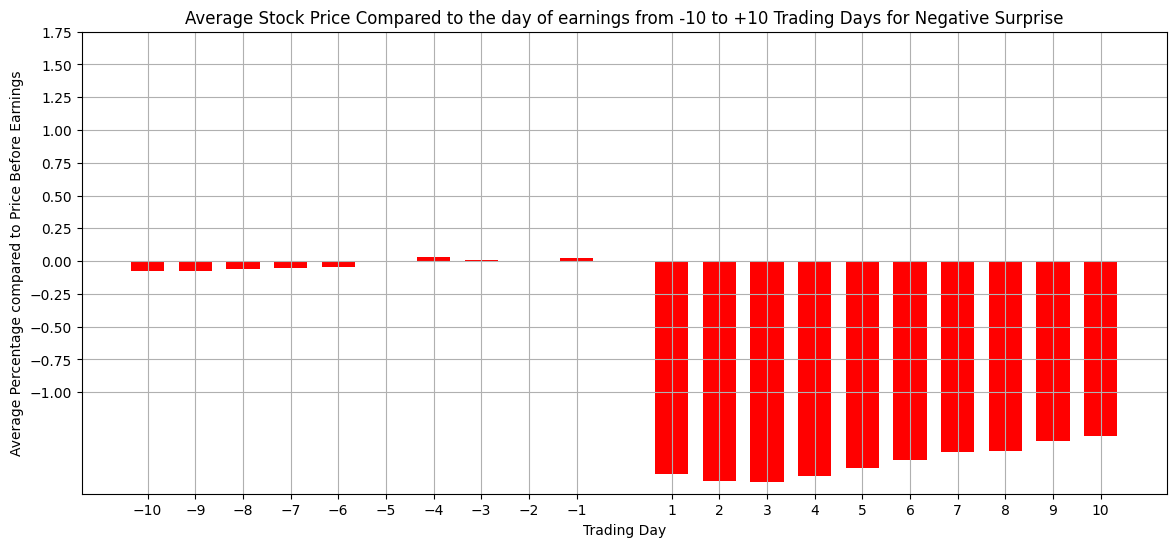

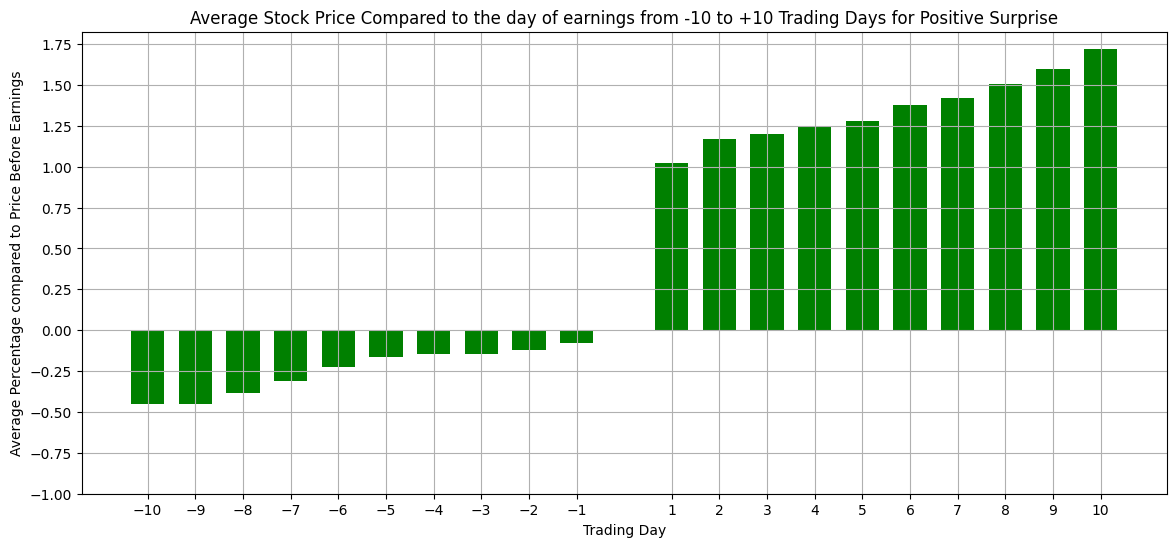

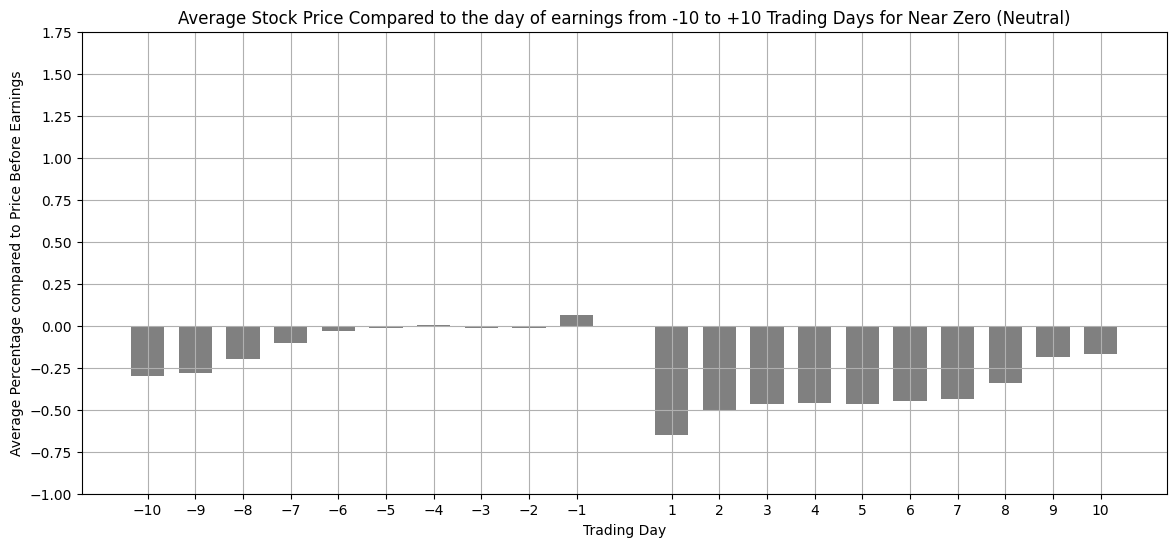

In [286]:
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_changes(data, category, color, title = None, y_min = -1):
    """
    Plot average stock price changes before and after earnings for a given category.

    Parameters:
    - data: DataFrame containing the filtered data for the category.
    - category: String name of the category (e.g., 'Negative Surprise').
    - color: Color for the 'After Earnings' bars.
    - title: Custom title for the plot.
    - y_min: The minimum value for the y axis.
    """
    percentage_changes = []

    # Calculate average changes from 10 days before to 10 days after earnings
    for day in range(10, 0, -1):  # Days before earnings (negative days)
        avg_before = data[f'change_{day}_days_before'].mean()
        percentage_changes.append(avg_before)
    
    for day in range(1, 11):  # Days after earnings (positive days)
        avg_after = data[f'change_{day}_days_after'].mean()
        percentage_changes.append(avg_after)

    days = np.concatenate((np.arange(-10, 0), np.arange(1, 11)))  # Days from -10 to +10

    plt.figure(figsize=(14, 6))

    plt.bar(days, percentage_changes, width=0.7, color=color)

    plt.title(title if title != None else  f'Average Stock Price Compared to the day of earnings from -10 to +10 Trading Days for {category}')
    plt.xlabel('Trading Day')
    plt.ylabel('Average Percentage compared to Price Before Earnings')
    plt.xticks(days)
    plt.yticks(np.arange(y_min, 2, step=0.25))
    plt.grid(True)
    plt.show()

# Filter data for each category
negative_surprise_data = merged_data[merged_data['eps_category'] == 'Negative Surprise']
positive_surprise_data = merged_data[merged_data['eps_category'] == 'Positive Surprise']
neutral_data = merged_data[merged_data['eps_category'] == 'Near Zero']

plot_avg_changes(negative_surprise_data, 'Negative Surprise', 'red')

plot_avg_changes(positive_surprise_data, 'Positive Surprise', 'green')

plot_avg_changes(neutral_data, 'Near Zero (Neutral)', 'gray')

TODO write something about above

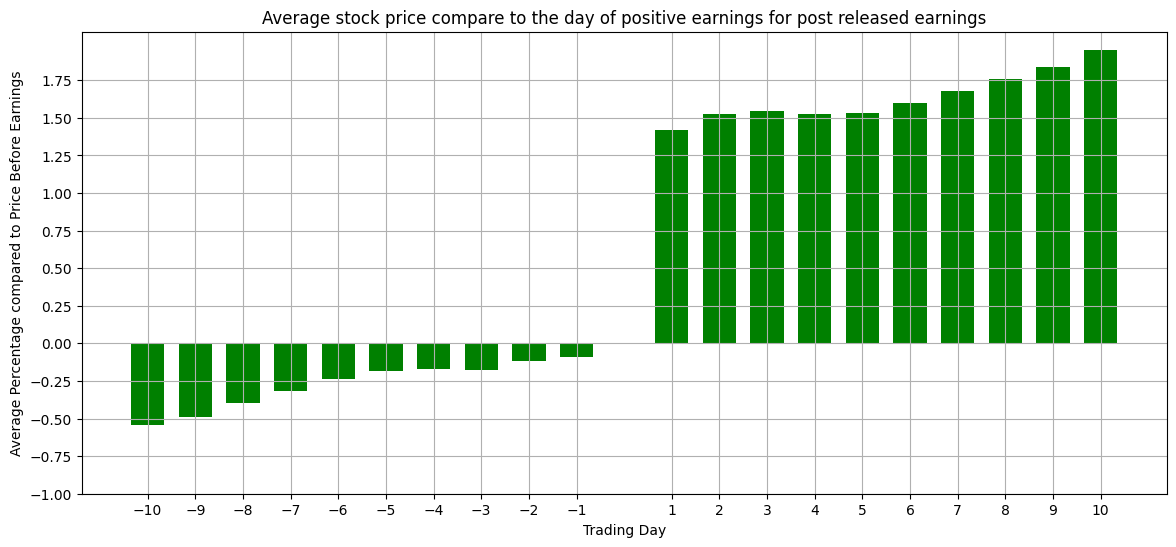

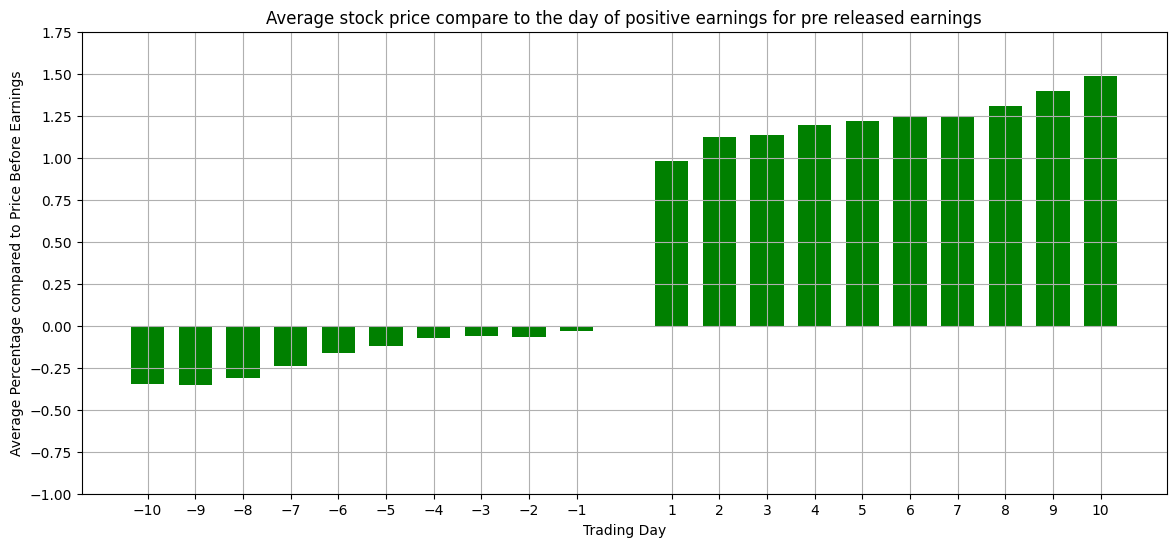

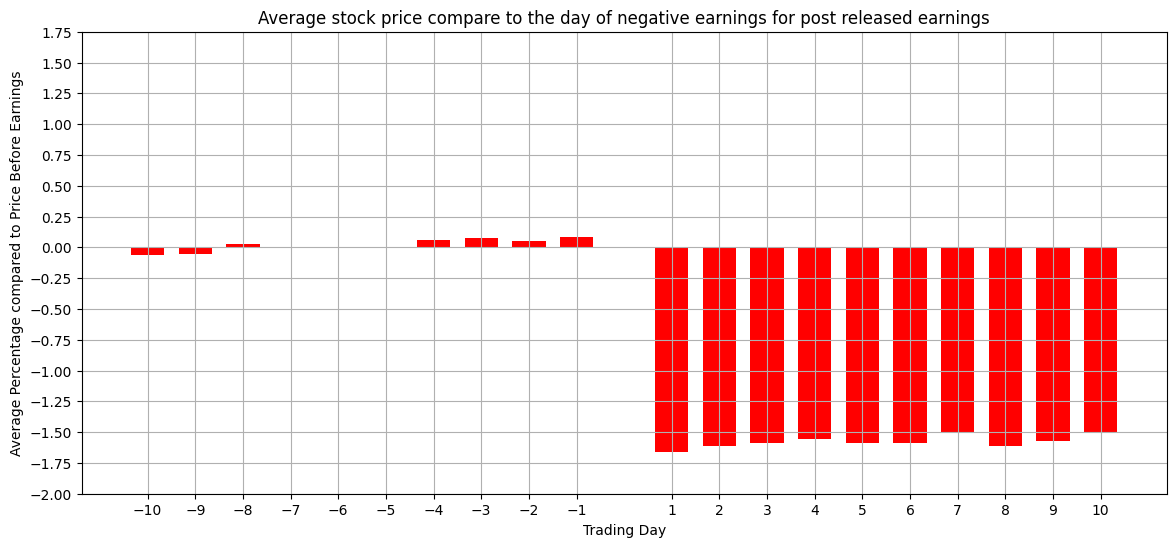

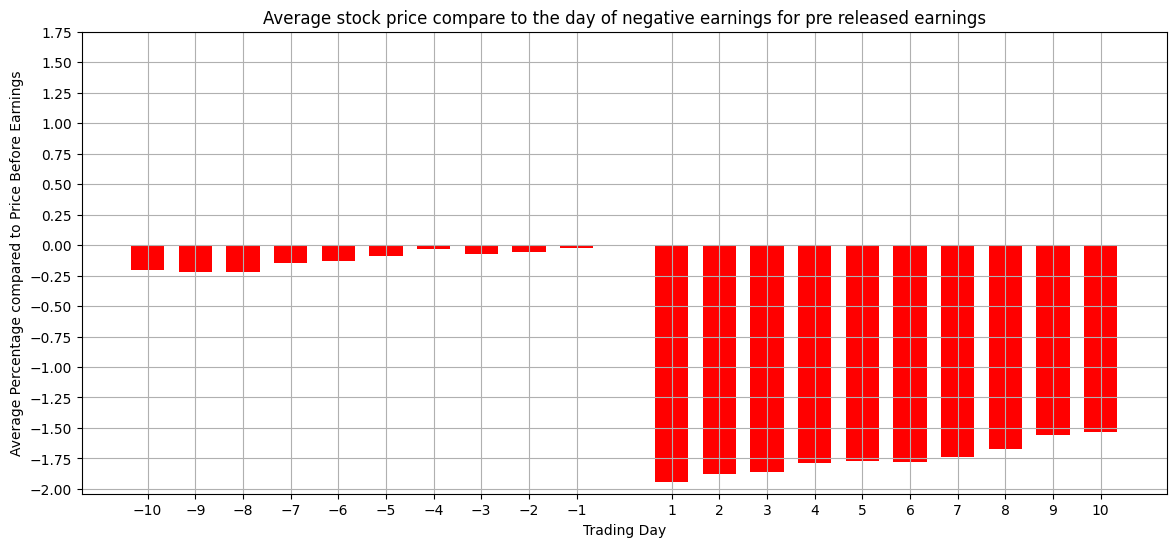

In [287]:
plot_avg_changes(positive_surprise_data[positive_surprise_data.release_time == 'post'], 'Positive Surprise', 'green', 'Average stock price compare to the day of positive earnings for post released earnings')
plot_avg_changes(positive_surprise_data[positive_surprise_data.release_time == 'pre'], 'Positive Surprise', 'green', 'Average stock price compare to the day of positive earnings for pre released earnings')

plot_avg_changes(negative_surprise_data[negative_surprise_data.release_time == 'post'], 'Negative Surprise', 'red', 'Average stock price compare to the day of negative earnings for post released earnings', -2)
plot_avg_changes(negative_surprise_data[negative_surprise_data.release_time == 'pre'], 'Negative Surprise', 'red', 'Average stock price compare to the day of negative earnings for pre released earnings', -2)

In [282]:
merged_data['earliest_available_price'] = merged_data[
    ['price_10_days_after', 'price_9_days_after', 'price_8_days_after', 'price_7_days_after', 
     'price_6_days_after', 'price_5_days_after', 'price_4_days_after', 'price_3_days_after', 
     'price_2_days_after', 'price_1_days_after']
].bfill(axis=1).iloc[:, 0]

In [283]:
merged_data['total_change_after_10_days'] = merged_data.apply(
        lambda row: calculate_diff_percent(row['earliest_available_price'], row['price_before_earnings']), axis=1
)

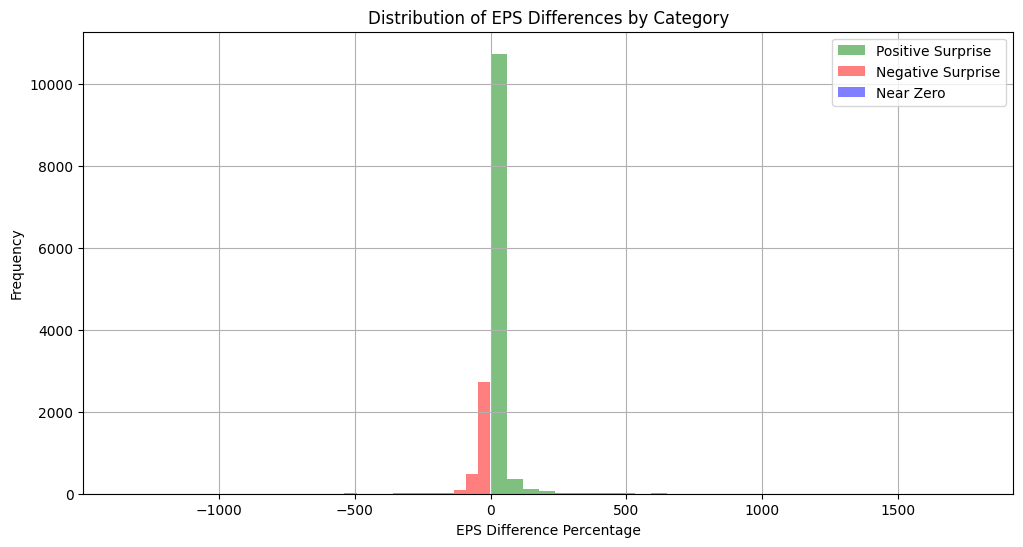

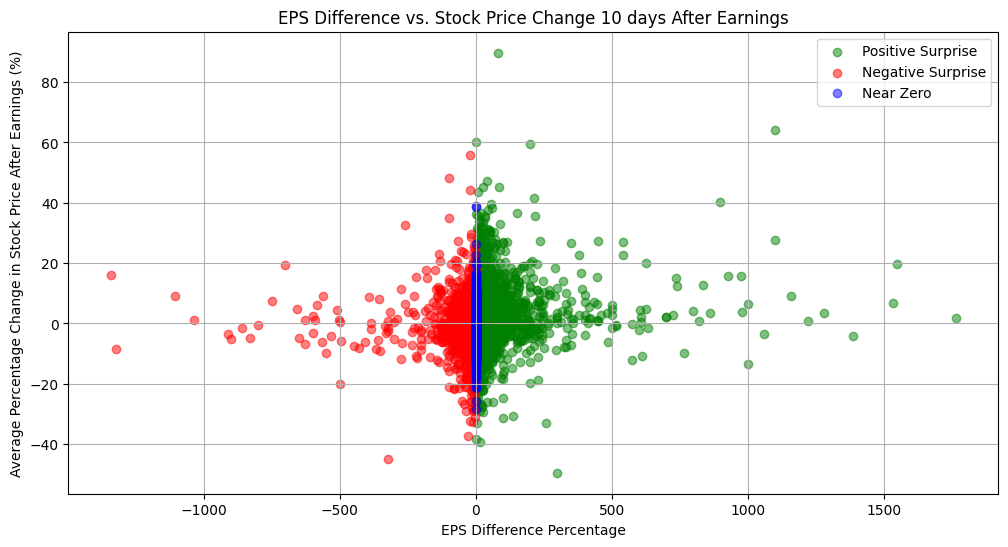

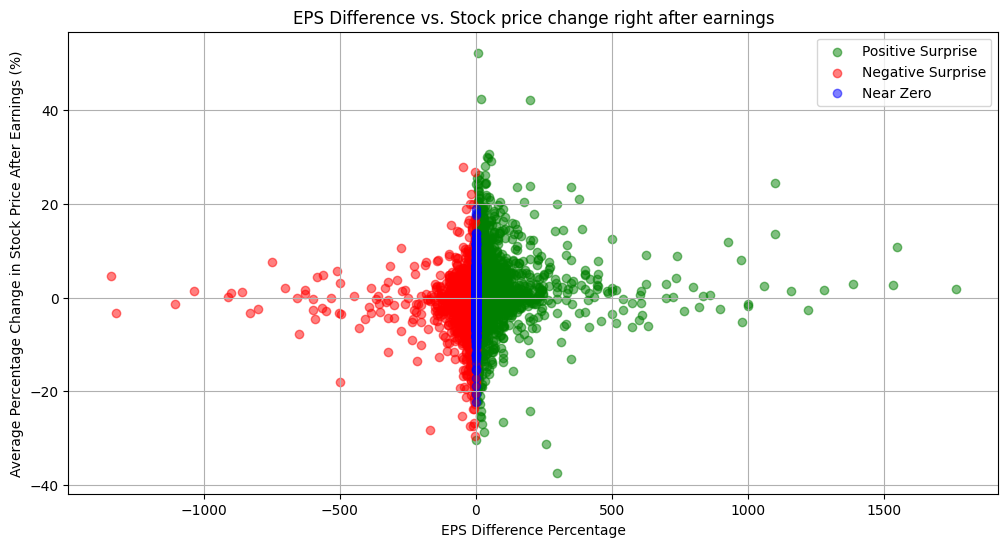

In [284]:
plt.figure(figsize=(12, 6))

if not merged_data[merged_data['eps_category'] == 'Positive Surprise']['eps_diff_percent'].empty:
    plt.hist(merged_data[merged_data['eps_category'] == 'Positive Surprise']['eps_diff_percent'], bins=30, alpha=0.5, label='Positive Surprise', color='green')

if not merged_data[merged_data['eps_category'] == 'Negative Surprise']['eps_diff_percent'].empty:
    plt.hist(merged_data[merged_data['eps_category'] == 'Negative Surprise']['eps_diff_percent'], bins=30, alpha=0.5, label='Negative Surprise', color='red')

if not merged_data[merged_data['eps_category'] == 'Near Zero']['eps_diff_percent'].empty:
    plt.hist(merged_data[merged_data['eps_category'] == 'Near Zero']['eps_diff_percent'], bins=30, alpha=0.5, label='Near Zero', color='blue')

plt.title('Distribution of EPS Differences by Category')
plt.xlabel('EPS Difference Percentage')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Visualization: Scatter plot of EPS differences vs. average stock price change after earnings
plt.figure(figsize=(12, 6))

categories = ['Positive Surprise', 'Negative Surprise', 'Near Zero']
colors = ['green', 'red', 'blue']

for category, color in zip(categories, colors):
    subset = merged_data[merged_data['eps_category'] == category]
    if not subset.empty:
        plt.scatter(subset['eps_diff_percent'], subset['total_change_after_10_days'], alpha=0.5, label=category, color=color)

plt.title('EPS Difference vs. Stock Price Change 10 days After Earnings')
plt.xlabel('EPS Difference Percentage')
plt.ylabel('Average Percentage Change in Stock Price After Earnings (%)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))

for category, color in zip(categories, colors):
    subset = merged_data[merged_data['eps_category'] == category]
    if not subset.empty:
        plt.scatter(subset['eps_diff_percent'], subset['change_1_days_after'], alpha=0.5, label=category, color=color)

plt.title('EPS Difference vs. Stock price change right after earnings')
plt.xlabel('EPS Difference Percentage')
plt.ylabel('Average Percentage Change in Stock Price After Earnings (%)')
plt.legend()
plt.grid(True)
plt.show()

TODO write something about above and clean up code

## 4. Investigating the Effect of Insider Trading on Stock Prices
- **Hypothesis**: Insider trading activity can be a predictor of stock price movements.
- **Data Analysis**:
  - Identifying patterns in insider trading data.
  - Correlation between insider trades and subsequent stock price movements.
- **Methods**:
  - Statistical analysis to detect abnormal returns post insider trading.
  - Machine learning models to predict price changes based on insider trades.
- **Visualization**: Display results and key findings.

## 5. Analyzing the Impact of Tweets on Stock Prices
- **Hypothesis**: Social media sentiment can influence stock prices.
- **Data Analysis**:
  - Sentiment analysis of tweets (positive, negative, neutral).
  - Correlation between tweet sentiment and stock price movements.
- **Methods**:
  - Text preprocessing and sentiment analysis using NLP techniques.
  - Time series analysis to link tweet sentiment to stock prices.
- **Visualization**: Display results and key findings.

## 6. Comparative Analysis and Synthesis of Findings
- **Comparison**: Compare the influence of tweets, insider trading, and earnings on stock prices.
- **Discussion**: Discuss which factor has the most significant impact.
- **Exploration**: Explore any potential interactions between these factors.

## 7. Conclusion and Recommendations
- **Summary**: Summarize key findings from the analyses.
- **Implications**: Practical implications for investors and financial analysts.
- **Future Research**: Recommendations for future research.

# TODO delete playground

In [51]:
# https://www.kaggle.com/datasets/rprkh15/sp500-stock-prices?select=AAPL.csv
# How are dividends calculated? -> they are in USD ($)
# ADD PERCCENTAGE CHANGE
# Think about stock price to dividend
# Think about stock splits as well?
# Stock split 1 to 7 split (prices are correctly adjusted for the split)
# Check biggest diffs in opea and close prices (as well as high and low)
# Does volumne impact the price. More volume -> more likely to go up or down?
# Do stock splits affect the price?

stock_data = pd.read_csv('stocks_data/MSFT.csv')
stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1986-03-13,0.055653,0.063838,0.055653,0.061109,1031788800,0.0,0.0
1,1986-03-14,0.061109,0.064384,0.061109,0.063292,308160000,0.0,0.0
2,1986-03-17,0.063292,0.064929,0.063292,0.064383,133171200,0.0,0.0
3,1986-03-18,0.064383,0.064929,0.062201,0.062746,67766400,0.0,0.0
4,1986-03-19,0.062746,0.063292,0.061109,0.061655,47894400,0.0,0.0
...,...,...,...,...,...,...,...,...
9152,2022-07-06,263.750000,267.989990,262.399994,266.209991,23824400,0.0,0.0
9153,2022-07-07,265.119995,269.059998,265.019989,268.399994,20859900,0.0,0.0
9154,2022-07-08,264.790009,268.100006,263.290009,267.660004,19648100,0.0,0.0
9155,2022-07-11,265.649994,266.529999,262.179993,264.510010,19455200,0.0,0.0


In [52]:
# https://www.kaggle.com/datasets/ilyaryabov/insider-trading-sp500-inside-info

insider_trading = pd.read_csv('insider_trading/MSFT.csv').sort_values(['Value ($)'], ascending = False)
insider_trading

,Insider Trading,Relationship,Date,Transaction,Cost,Shares,Value ($),Shares Total,SEC Form 4
1,SMITH BRADFORD L,President and Vice Chair,2022-02-08,Sale,304.64,"27,860","8,487,170","622,460",Feb 09 06:16 PM
4,List Teri,Director,2021-12-07,Sale,334.90,"1,650","552,578","1,654",Dec 08 05:59 PM
3,Walmsley Emma N,Director,2022-01-28,Buy,295.48,"1,700","502,317","7,086",Feb 01 06:15 PM
9,Hogan Kathleen T,"EVP, Human Resources",2021-09-10,Sale,298.68,"20,000","5,973,540","183,988",Sep 13 06:05 PM
2,Walmsley Emma N,Director,2022-01-31,Buy,311.53,"1,600","498,445","8,686",Feb 01 06:15 PM
11,Nadella Satya,Chief Executive Officer,2021-09-01,Sale,303.28,"75,573","22,920,037","1,669,375",Sep 01 08:12 PM
10,Capossela Christopher C,"EVP, Chief Marketing Officer",2021-09-10,Sale,298.82,"10,000","2,988,176","94,415",Sep 13 06:03 PM
0,Nadella Satya,Chief Executive Officer,2022-03-01,Sale,296.52,"7,931","2,351,736","809,645",Mar 02 06:20 PM
7,Althoff Judson,"EVP, Chief Commercial Officer",2021-11-02,Sale,332.28,"54,757","18,194,837","139,586",Nov 03 06:13 PM
12,Hood Amy,"EVP, Chief Financial Officer",2021-09-01,Sale,303.08,"60,000","18,184,980","463,259",Sep 03 06:05 PM


In [53]:
# https://www.kaggle.com/datasets/cnic92/200-financial-indicators-of-us-stocks-20142018
# we have data per year, is it cleaned data?
# also maybe check this out

financial_indicators = pd.read_csv('financial_indicators/2018_Financial_Data.csv')
financial_indicators

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class
0,CMCSA,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,...,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical,32.794573,1
1,KMI,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,...,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,Energy,40.588068,1
2,INTC,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,...,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,Technology,30.295514,1
3,MU,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,...,0.4573,0.1511,0.2275,0.6395,-0.5841,0.1738,0.0942,Technology,64.213737,1
4,GE,1.216150e+11,0.0285,9.546100e+10,2.615400e+10,0.000000e+00,1.811100e+10,4.071100e+10,-1.455700e+10,5.059000e+09,...,-0.2781,-0.2892,-0.1575,-0.4487,-0.2297,0.0000,0.0308,Industrials,44.757840,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,YRIV,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,3.755251e+06,3.755251e+06,-3.755251e+06,1.105849e+07,...,0.0000,0.0000,-0.0508,-0.1409,-0.0152,0.0000,-0.2602,Real Estate,-90.962099,0
4388,YTEN,5.560000e+05,-0.4110,0.000000e+00,5.560000e+05,4.759000e+06,5.071000e+06,9.830000e+06,-9.274000e+06,0.000000e+00,...,0.3445,0.0000,-0.2323,-0.8602,0.0000,0.0352,-0.0993,Basic Materials,-77.922077,0
4389,ZKIN,5.488438e+07,0.2210,3.659379e+07,1.829059e+07,1.652633e+06,7.020320e+06,8.672953e+06,9.617636e+06,1.239170e+06,...,0.1605,0.7706,0.2489,0.4074,-0.0968,0.2415,0.8987,Basic Materials,-17.834400,0
4390,ZOM,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,1.031715e+07,4.521349e+06,1.664863e+07,-1.664863e+07,0.000000e+00,...,0.8980,0.0000,0.1568,-0.2200,0.0000,2.7499,0.1457,Industrials,-73.520000,0


In [54]:
# twitter data https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction
# also maybe check this out

tweet_data = pd.read_csv('tweet_data/stock_tweets.csv')
tweet_data

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [55]:
# earnings data https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data

earnings_data = pd.read_csv('earnings_data/earnings_latest.csv')
earnings_data

,symbol,date,qtr,eps_est,eps,release_time
0,A,2009-05-14,04/2009,NaN,NaN,post
1,A,2009-08-17,07/2009,NaN,NaN,post
2,A,2009-11-13,10/2009,NaN,NaN,pre
3,A,2010-02-12,01/2010,NaN,NaN,pre
4,A,2010-05-17,04/2010,NaN,NaN,post
...,...,...,...,...,...,...
168598,ZYXI,2020-02-27,Q4,0.077,0.09,post
168599,ZYXI,2020-04-28,Q1,0.063,0.09,post
168600,ZYXI,2020-07-28,Q2,0.086,0.09,post
168601,ZYXI,2020-10-27,Q3,0.053,0.04,post


If have time -> check institutional investments